<a href="https://colab.research.google.com/github/snehalad/flower-image-classification-tensorflow/blob/main/Transfer_learning_Imageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow 

Transfer learning is when a model developed for one task is reused to work on a second task.

till now i know,
- Feature learning
- Fine tuning


## Let's get some data

In [ ]:
# import libararies
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
# view available tesnorflow dataset
# tfds.list_builders()

### Download Dataset and split it into 70-30 percentage

In [ ]:
(training_data, testing_data), dataset_info = tfds.load('tf_flowers',
                                                        split=['train[:70%]', 'train[70%:]'],
                                                        with_info=True,
                                                        as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# what is in dataset_info
dataset_info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1.incomplete6H0MUN',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [ ]:
training_data, testing_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

### Creating helper function

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-21 06:28:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-21 06:28:58 (71.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [ ]:
# Total training and testing data
print(f"Total Training data: {len(training_data)}")
print(f"Total Testing data: {len(testing_data)}")

Total Training data: 2569
Total Testing data: 1101


### Visualize our data

In [ ]:
class_names = dataset_info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

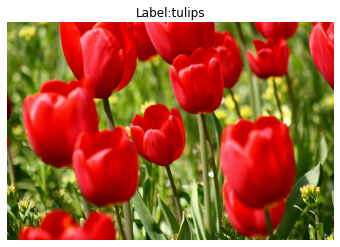

(333, 500, 3)


In [ ]:
import random 
import matplotlib.pyplot as plt

for image, label in training_data.take(1):
  break
image = image.numpy()
plt.imshow(image)
plt.title(f"Label:{class_names[label]}")
plt.axis(False)
plt.show()
print(image.shape)

### Reformat images and create batches

In [ ]:
# make batches
IMAGE_RES = 224
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label
BATCH_SIZE = 32
train_batches = training_data.shuffle(len(training_data)//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = testing_data.map(format_image).batch(BATCH_SIZE).prefetch(1)
print(train_batches)
print(validation_batches)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


### Creating model using Tensorflow Hub

In [ ]:
# tensorflow hub model url
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=5):
  # download model and save it
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=(224, 224, 3))
  # create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation="softmax", name="output_layer")
  ])

  return model

In [ ]:
# pass parameters to our model function
model_mobilenet_v2 = create_model(url,
                                  num_classes=5)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model_mobilenet_v2.compile(loss="sparse_categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [ ]:
model_mobilenet_v2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# how many layers are in our pre trained model
len(model_mobilenet_v2.layers[0].weights)

260

In [ ]:
history = model_mobilenet_v2.fit(train_batches,
                                 epochs=5,
                                 steps_per_epoch=len(train_batches),
                                 validation_data=validation_batches,
                                 validation_steps=len(validation_batches),
                                 callbacks=[create_tensorboard_callback(dir_name="tesnorflow_hub",
                                                                       experiment_name="flower_classification")])

Saving TensorBoard log files to: tesnorflow_hub/flower_classification/20230321-062902
Epoch 1/5
81/81 [==============================] - 32s 173ms/step - loss: 0.7914 - accuracy: 0.7061 - val_loss: 0.4639 - val_accuracy: 0.8392
Epoch 2/5
81/81 [==============================] - 6s 77ms/step - loss: 0.3875 - accuracy: 0.8770 - val_loss: 0.3701 - val_accuracy: 0.8728
Epoch 3/5
81/81 [==============================] - 5s 58ms/step - loss: 0.3108 - accuracy: 0.8992 - val_loss: 0.3293 - val_accuracy: 0.8837
Epoch 4/5
81/81 [==============================] - 6s 73ms/step - loss: 0.2579 - accuracy: 0.9206 - val_loss: 0.3049 - val_accuracy: 0.8983
Epoch 5/5
81/81 [==============================] - 4s 49ms/step - loss: 0.2191 - accuracy: 0.9327 - val_loss: 0.2973 - val_accuracy: 0.8955


In [ ]:
model_mobilenet_v2.evaluate(validation_batches)

35/35 [==============================] - 1s 34ms/step - loss: 0.2973 - accuracy: 0.8955


[0.29728561639785767, 0.895549476146698]

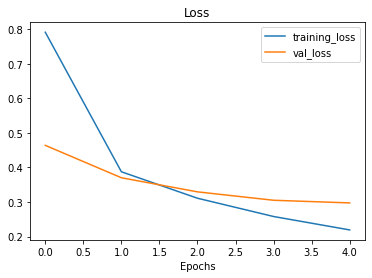

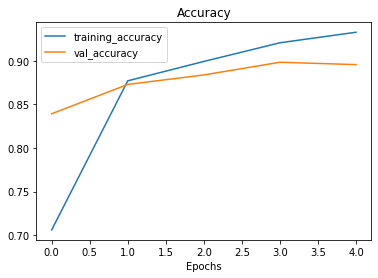

In [ ]:
plot_loss_curves(history)

### Let's make Predictions

In [ ]:
# create a function to import and resize it 
def load_and_prep_image(filename, img_shape=224):
  # read in the image
  img = tf.io.read_file(filename)
  # decode the read file into a tensor
  img = tf.image.decode_image(img)
  # resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # rescale the image (get all values between 0 and 1)
  img = img/255
  return img

In [ ]:
# reconfig function
def pred_and_plot(model, filename, class_names=class_names):
  """
  imports an image located at filename, make a prediction with model and 
  plots the image with the predicted class as the title
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # make predictions
  pred = model.predict(tf.expand_dims(img, axis=0))
  print(tf.argmax(pred[0]))
  # Add in logic for multi class and get pred_class name
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]
  print(pred_class)
  # plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Predicted:{pred_class}")
  plt.axis(False)

--2023-03-21 06:30:03--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQup-EzeU7ko7TcHkpxCagEFwXPrEoxr94YZQUqCgeQ&s
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 64.233.191.101, 64.233.191.138, 64.233.191.100, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|64.233.191.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2960 (2.9K) [image/jpeg]
Saving to: ‘images?q=tbn:ANd9GcQup-EzeU7ko7TcHkpxCagEFwXPrEoxr94YZQUqCgeQ&s’

images?q=tbn:ANd9Gc 100%[===================>]   2.89K  --.-KB/s    in 0s      

2023-03-21 06:30:03 (42.6 MB/s) - ‘images?q=tbn:ANd9GcQup-EzeU7ko7TcHkpxCagEFwXPrEoxr94YZQUqCgeQ&s’ saved [2960/2960]

1/1 [==============================] - 1s 738ms/step
tf.Tensor(4, shape=(), dtype=int64)
roses


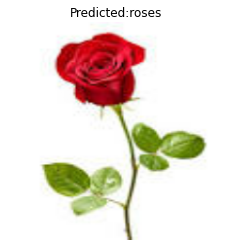

In [ ]:
# Let's test our model
!wget "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQup-EzeU7ko7TcHkpxCagEFwXPrEoxr94YZQUqCgeQ&s"
pred_and_plot(model_mobilenet_v2, "images?q=tbn:ANd9GcQup-EzeU7ko7TcHkpxCagEFwXPrEoxr94YZQUqCgeQ&s", class_names)

--2023-03-21 06:30:04--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRTJPxYV8fLFt0NSdU9dBRN7Uoqht7A9ghljeITPljGUg&s
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 64.233.191.101, 64.233.191.138, 64.233.191.100, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|64.233.191.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3708 (3.6K) [image/jpeg]
Saving to: ‘images?q=tbn:ANd9GcRTJPxYV8fLFt0NSdU9dBRN7Uoqht7A9ghljeITPljGUg&s’

images?q=tbn:ANd9Gc 100%[===================>]   3.62K  --.-KB/s    in 0s      

2023-03-21 06:30:04 (55.4 MB/s) - ‘images?q=tbn:ANd9GcRTJPxYV8fLFt0NSdU9dBRN7Uoqht7A9ghljeITPljGUg&s’ saved [3708/3708]

1/1 [==============================] - 0s 43ms/step
tf.Tensor(0, shape=(), dtype=int64)
dandelion


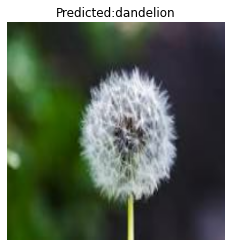

In [ ]:
!wget "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRTJPxYV8fLFt0NSdU9dBRN7Uoqht7A9ghljeITPljGUg&s"
pred_and_plot(model_mobilenet_v2, "images?q=tbn:ANd9GcRTJPxYV8fLFt0NSdU9dBRN7Uoqht7A9ghljeITPljGUg&s", class_names)

--2023-03-21 06:30:04--  https://cdn.pixabay.com/photo/2016/01/08/05/24/sunflower-1127174__340.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.15.16, 104.18.14.16, 2606:4700::6812:e10, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.15.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30595 (30K) [image/jpeg]
Saving to: ‘sunflower-1127174__340.jpg’

sunflower-1127174__ 100%[===================>]  29.88K  --.-KB/s    in 0.001s  

2023-03-21 06:30:04 (22.0 MB/s) - ‘sunflower-1127174__340.jpg’ saved [30595/30595]

1/1 [==============================] - 0s 42ms/step
tf.Tensor(3, shape=(), dtype=int64)
sunflowers


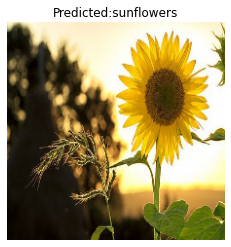

In [ ]:
!wget "https://cdn.pixabay.com/photo/2016/01/08/05/24/sunflower-1127174__340.jpg"
pred_and_plot(model_mobilenet_v2, "sunflower-1127174__340.jpg", class_names)

--2023-03-21 06:30:05--  https://cdn.pixabay.com/photo/2017/04/23/20/36/tulips-2254970__340.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.15.16, 104.18.14.16, 2606:4700::6812:e10, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.15.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34145 (33K) [binary/octet-stream]
Saving to: ‘tulips-2254970__340.jpg’

tulips-2254970__340 100%[===================>]  33.34K  --.-KB/s    in 0.002s  

2023-03-21 06:30:05 (16.7 MB/s) - ‘tulips-2254970__340.jpg’ saved [34145/34145]

1/1 [==============================] - 0s 38ms/step
tf.Tensor(2, shape=(), dtype=int64)
tulips


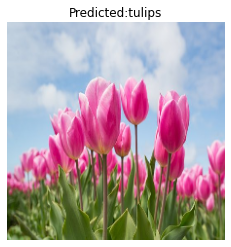

In [ ]:
!wget "https://cdn.pixabay.com/photo/2017/04/23/20/36/tulips-2254970__340.jpg"
pred_and_plot(model_mobilenet_v2, "tulips-2254970__340.jpg", class_names)

--2023-03-21 06:30:06--  https://cdn.pixabay.com/photo/2015/04/19/08/32/marguerite-729510__340.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.15.16, 104.18.14.16, 2606:4700::6812:e10, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.15.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18759 (18K) [binary/octet-stream]
Saving to: ‘marguerite-729510__340.jpg’

marguerite-729510__ 100%[===================>]  18.32K  --.-KB/s    in 0.001s  

2023-03-21 06:30:06 (35.6 MB/s) - ‘marguerite-729510__340.jpg’ saved [18759/18759]

1/1 [==============================] - 0s 48ms/step
tf.Tensor(1, shape=(), dtype=int64)
daisy


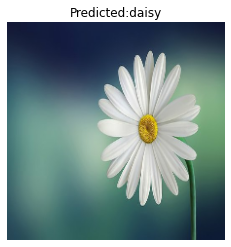

In [ ]:
!wget "https://cdn.pixabay.com/photo/2015/04/19/08/32/marguerite-729510__340.jpg"
pred_and_plot(model_mobilenet_v2, "marguerite-729510__340.jpg", class_names)

### Save model

In [ ]:
model_mobilenet_v2.save("Model")

In [ ]:
tf.keras.models.save_model(model_mobilenet_v2, "flower_class_model.hdf5")

In [ ]:
from google.colab import files
files.download('/content/Model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/Model.zip /content/Model

  adding: content/Model/ (stored 0%)
  adding: content/Model/assets/ (stored 0%)
  adding: content/Model/variables/ (stored 0%)
  adding: content/Model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/Model/variables/variables.index (deflated 78%)
  adding: content/Model/keras_metadata.pb (deflated 81%)
  adding: content/Model/saved_model.pb (deflated 92%)
  adding: content/Model/fingerprint.pb (stored 0%)


In [ ]:
files.download('/content/Model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>